#  U-Net Test: CT Bone Segmentation

In [8]:
from PIL import Image
import numpy as np
import scipy.io as scio
import glob
import torch

import torch.nn as nn
import torch.nn.functional as F
import os
import random
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

from utils import match_files_from_patient, readBinImage, readUCharImage, get_spine_mask_v2
from dataset import CTMaskDataset, CTPTMaskDataset
from model import UNet
from train import train_net, test_net
from losses import FocalLoss, MixedLoss, dice, IoU

import imgaug as iaa
from datetime import datetime
import pickle

## Define Datasets
Get the CT and label mask files into Datasets.

In [9]:
train_patient_idxs = [1, 2, 4, 5]
train_dev_data = []
for idx in train_patient_idxs:
    for day_selection in range(1,4):
        patient_data = match_files_from_patient(idx, day_selection, mode='CT_PT_SPINE')
        train_dev_data.extend(patient_data)
        
test_patient_idxs = [3, 6]
test_data = []
for idx in test_patient_idxs:
    for day_selection in range(1,4):
        patient_data = match_files_from_patient(idx, day_selection, mode='CT_PT_SPINE')
        test_data.extend(patient_data)

seed = 544
K = int(0.1 * len(train_dev_data))
np.random.shuffle(train_dev_data)
dev_data = train_dev_data[:K]
train_data = train_dev_data[K:]
print('train: {}, dev: {}, test: {}'.format(len(train_data), len(dev_data), len(test_data)))

batch_size = 2

train_dataset = CTPTMaskDataset(train_data)
train_generator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
dev_dataset = CTPTMaskDataset(dev_data, offset=(0,0), output_size=(512, 512), augment=False)
dev_generator = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

train: 1985, dev: 220, test: 1176


## Dataset verification
Check the dataset containers for correct data and shape.

458 (2, 320, 320) (1, 320, 320)


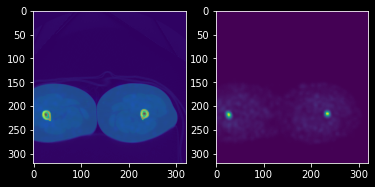

In [10]:
idx = np.random.choice(len(train_dataset))
sample_data = train_dataset[idx]

ct_pt = sample_data['data']
ct, pt = ct_pt[0, :, :], ct_pt[1, :, :]
mask = sample_data['label']
print(idx, ct_pt.shape, mask.shape)

fig = plt.Figure(figsize=(10,20))
ax = plt.subplot(1,2,1)
ax.imshow(ct)
#ax.imshow(mask, alpha=0.7, cmap='jet')
ax.imshow(pt, alpha=0.3, cmap='jet')
bx = plt.subplot(1,2,2)
bx.imshow(pt)
plt.show()

## Training and test functions from torch.nn
These are actually also in train.py so can probably remove this cell... just need to check compatible....

In [11]:
def test_net(model, 
             device, 
             test_generator,  
             print_log=False):
    
    model.eval()
    
    dice_score = 0.0
    iou_score = 0.0
    correct = 0.0
    
    with torch.no_grad():
        for i, batch_data in enumerate(test_generator):
            cts = batch_data['data']
            cts = cts.to(device)

            labels = batch_data['label']
            labels = labels.to(device)

            outputs = model(cts)

            masks_probs = outputs

            dice_ = dice(masks_probs, labels)
            iou_ = IoU(masks_probs, labels)

            dice_score += dice_.item()
            iou_score += iou_.item()
            
    dice_score /= len(test_generator)
    iou_score /= len(test_generator)
    
    if print_log == True:
        print('\tTest set: dice score: {:.4f}, iou score: {:.4f}\n'.format(dice_score, iou_score))
    
    return dice_score, iou_score

## Create datalog folder

In [12]:

current_datetime = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
output_directory = 'logs-' + current_datetime
if not os.path.isdir(output_directory):
    os.makedirs(output_directory)

## Training initialization
Defines initial hyperparameters for learning, loss criterion, optimizer, etc...

In [13]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# model hyperparameters
lr_model = 0.0003
decay_step_size = 500
gamma = 2.0
focal_gain = 10.0

# declare model
channel_in, num_classes = 2, 1
model = UNet(channel_in, num_classes)
model.to(device)

# learning schema
criterion = MixedLoss(focal_gain, gamma)
optimizer = torch.optim.Adam(model.parameters(), lr=lr_model)
learning_scheduler = lr_scheduler.StepLR(optimizer, step_size=decay_step_size, gamma=0.1)

num_epochs = 200
ckpt_save_interval = 2

# loss log initialization
train_losses = []
val_losses = []
best_score = 0.0


## Training loop
General training scheme

In [14]:
for epoch in range(num_epochs):
    # run training step
    train_loss = train_net(model, 
                           device, 
                           train_generator,
                           batch_size,
                           criterion, 
                           optimizer,
                           learning_scheduler,
                           epoch, 
                           log_interval=100, 
                           print_log=True)

    # run validation step
    val_loss = test_net(model, 
                        device, 
                        dev_generator, 
                        print_log=True)

    # save best models
    if val_loss[0] > best_score:
        best_score = val_loss[0]
        torch.save(model.state_dict(), 
                   '{}/ckpt.model-{}.pt'.format(output_directory, epoch))

    # record losses to logs
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Train Epoch: 0 [0/1985 (0%)]	Loss: 0.937626
Train Epoch: 0 [200/1985 (10%)]	Loss: 0.149901
Train Epoch: 0 [400/1985 (20%)]	Loss: 0.090648
Train Epoch: 0 [600/1985 (30%)]	Loss: 0.057674
Train Epoch: 0 [800/1985 (40%)]	Loss: 0.036720
Train Epoch: 0 [1000/1985 (50%)]	Loss: 0.028423
Train Epoch: 0 [1200/1985 (60%)]	Loss: 0.021093
Train Epoch: 0 [1400/1985 (70%)]	Loss: 0.015277
Train Epoch: 0 [1600/1985 (81%)]	Loss: 0.013590
Train Epoch: 0 [1800/1985 (91%)]	Loss: 0.011049
	Test set: dice score: 0.6388, iou score: 0.5408



NameError: name 'train_losses' is not defined

In [ ]:
dice_scores, iou_scores = zip(*val_losses)
n = range(0, len(dice_scores))
fig = plt.figure(figsize=(12,8))
plt.plot(n, dice_scores, label='dice')
plt.plot(n, iou_scores, label='iou')
plt.grid('on')
plt.legend()

In [ ]:
# Plot train results

In [ ]:
dice_scores, iou_scores = zip(*gamma_val_loss)
n = range(0, len(dice_scores))
fig = plt.figure(figsize=(12,8))
plt.plot(n, dice_scores, label='dice')
plt.plot(n, iou_scores, label='iou')
plt.grid('on')
plt.legend()

In [ ]:
import pickle
with open('val-dice-iou-{}.pkl'.format(output_directory), 'wb') as f:
    pickle.dump(gamma_train_loss, f)
    pickle.dump(gamma_val_loss, f)

In [ ]:
with open('val-dice-iou.pkl', 'rb') as f:
    a = pickle.load(f)

In [ ]:
# Inference test

In [ ]:
ckpt_path = 'ckpt.model-87.pt'

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = UNet(2,1)
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(device)
model.eval()

In [ ]:
patient_idx = 9
day_selection = 1

patient_data = get_ct_pt_mask_data(patient_idx, day_selection)
test_dataset = CTPTMaskDataset(patient_data, offset=(96, 96), output_size=(512, 512), augment=False)
test_generator = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=10)

test_loss = 0.0
correct = 0.0

spine_masks = np.zeros((len(patient_data), 512, 512))
ct_images = np.zeros((len(patient_data), 2, 512, 512))
with torch.no_grad():
    for idx in range(0, len(patient_data)):
        batch_data = test_dataset[idx]
        ct_data = batch_data['data']
        ct_images[idx, :, :] = ct_data
        
        cts = np.expand_dims(ct_data, axis=0)
        cts = torch.from_numpy(cts).to(device)

        outputs = model(cts)
        masks_probs = torch.squeeze(F.sigmoid(outputs))
        mask = masks_probs.cpu().numpy()
        spine_masks[idx, :, :] = mask
        
scio.savemat(os.path.join(output_directory, 'test-{}-{}.mat'.format(patient_idx, day_selection)), 
             {'mask':np.transpose(spine_masks, [1, 2, 0]),
              'ct': np.transpose(ct_images, [0, 2, 3, 1])})

In [ ]:
#import scipy.io as scio

In [ ]:
# a = scio.loadmat('/home/chuong/MedicalResearch/Patient_02_2012-04-24.mat')

In [ ]:
#a.keys()

In [ ]:
#b = a['ct_info']

In [ ]:
from utils import get_spine_mask

In [ ]:
#mat_fname = '/backup_data1/ChuongWork/medical_imaging_data/SplineMat-11122015/Patient_15_2014-05-19.mat'
mat_fname = '/media/chuong/WDRED3TB/ChuongWork/medical_imaging_data/SplineMat-11122015/Patient_15_2014-05-19.mat'
get_spine_mask_v2(mat_fname, model, output_directory)

In [ ]:
data_path = '/media/chuong/WDRED3TB/ChuongWork/medical_imaging_data/SplineMat-11122015'
with open(data_path + '/blah.txt') as f:
    patient_list = f.readlines()
#patient_list

In [ ]:
data_path = '/media/chuong/WDRED3TB/ChuongWork/medical_imaging_data/SplineMat-11122015'
with open(data_path + '/blah.txt') as f:
    patient_list = f.readlines()
    
for patient_info in patient_list:
    patient = patient_info.replace('\n', '')
    mat_fname = os.path.join(data_path, patient)
    print('Doing {} ....... '. format(mat_fname))
    get_spine_mask_v2(mat_fname, model, output_directory)
   
    
#data_path = '/home/chuong/MedicalResearch/'
data_path = '/media/photography_main/CHUONG_DATA/ChuongWork/Research/MedicalImaging/OUBone/MedicalImaging/MatlabCode'
with open(data_path + 'tempPatientList.txt') as f:
    patient_list = f.readlines()
    
for patient_info in patient_list:
    patient = patient_info.replace('\n', '')
    mat_fname = os.path.join(data_path, patient)
    print('Doing {} ....... '. format(mat_fname))
    get_spine_mask_v2(mat_fname, model, output_directory)    
    

In [ ]:
data_path = '/media/photography_main/CHUONG_DATA/ChuongWork/Research/MedicalImaging/OUBone/MedicalImaging/MatlabCode/'
with open(data_path + 'tempPatientList.txt') as f:
    patient_list = f.readlines()
    
for patient_info in patient_list:
    patient = patient_info.replace('\n', '')
    mat_fname = os.path.join(data_path, patient)
    print('Doing {} ....... '. format(mat_fname))
    get_spine_mask_v2(mat_fname, model, output_directory)    

In [ ]:
patient_idx = 9
day_selection = 1

patient_data = get_ct_pt_mask_data(patient_idx, day_selection)
test_dataset = CTPTMaskDataset(patient_data, augment=False)
test_generator = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=10)

In [ ]:
#import numpy as np
rand_idx = random.randint(0, len(patient_data))
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].imshow(ct_images[rand_idx, 0, :, :][150:350, 150:350])
axs[0].imshow(ct_images[rand_idx, 1, :, :][150:350, 150:350], alpha=0.4, cmap='jet')
axs[1].imshow(ct_images[rand_idx, 1, :, :][150:350, 150:350], alpha=1, cmap='jet') 
axs[2].imshow(spine_masks[rand_idx, :, :][150:350, 150:350], alpha= 1.0)
#axs[0].imshow(ct_images[rand_idx, :, :, 0][100:300,100:250])
#axs[0].imshow(ct_images[rand_idx, :, :, 1][100:300,100:250])
#axs[1].imshow(spine_masks[rand_idx, :, :][100:300,100:250], alpha= 1.0)
plt.show()

In [ ]:
#import hdf5

In [ ]:
import scipy.io as scio

In [ ]:
t = scio.loadmat('/')

In [ ]:
mat_dir = '/data1/CHUONG_DATA/ChuongWork/medical_imaging_data/SplineMat-11122015'

In [ ]:
!ls '/data1/CHUONG_DATA/ChuongWork/medical_imaging_data/SplineMat-11122015'

In [ ]:
ct_fname = '../CT-PT-Images/P01/Day_1/CT/P_01_100.bin'

In [ ]:
c = readBinImage(ct_fname)

In [ ]:
plt.imshow(c)
plt.show()

In [ ]:
pt_fname = '../CT-PT-Images/P01/Day_3/PT/P_01_180.bin'

In [ ]:
d = readBinImage(pt_fname, (144, 144))

In [ ]:
plt.imshow(d[50:80,50:100])
plt.show()

In [ ]:
slice_idx = 160
ct_fname = '../CT-PT-Images/P01/Day_1/CT/P_01_{}.bin'.format(slice_idx)
ct_mask_fname = '../UCharImages/P1_1_{}.uchar'.format(slice_idx)

#ct_fname, ct_mask_fname = c[50]

mask = readUCharImage(ct_mask_fname)
ct = readBinImage(ct_fname, (512, 512))

# plot
fig = plt.Figure(figsize=(20,20))
ax = plt.subplot(1,2,1)
ax.imshow(ct)
ax2 = plt.subplot(1,2,2)
ax2.imshow(mask, alpha=1.0)
plt.show()

#fig = plt.Figure(figsize=(10,10))


#plt.show()



In [ ]:
np.max(ct)

In [ ]:

#fig = plt.Figure(figsize=(6,4))
#ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
#ax2 = plt.subplot(1,2,2)
#ax2.imshow(ct)
#plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(a)

In [ ]:
plt.show()

In [ ]:
file = open(ct_fname, 'rb')
rawData = file.read()
img = Image.frombytes('I', (512,512), rawData)

In [ ]:
b = np.array(img)

In [ ]:
plt.matshow(b.T)
plt.show()

In [ ]:
np.max(b)

In [ ]:
np.min(b)

In [ ]:
np.mean(b)

In [ ]:
import glob

# CLEAN P21, Day 2

In [ ]:
dir_name = '/backup_data1/ChuongWork/medical_imaging_data/ChuongVerifiedData/Patient_21/11-C-0136_0021_CT_2015-03-27_145745_PET.CT.(MIC).FLT.Lupron_LD.CT.600FOV_n255__00000'
fnames = glob.glob(dir_name + '/*.dcm')

In [ ]:
import os
import glob

In [ ]:
patient_idx = 1
day_selection = 1
ct_org_path='../CT-PT-Images'
ct_pattern = '{}/P{:02d}/Day_{}/CT/P_{:02d}'.format(ct_org_path, patient_idx, day_selection, patient_idx)
print(ct_pattern)
ct_fnames = glob.glob(ct_pattern + '*.bin')
len(ct_fnames)

In [ ]:
pt_fnames = []
for fname in ct_fnames:
    frame_idx = int(os.path.basename(fname).split('_')[2][:3])
    pt_fname = '{}/P{:02d}/Day_{}/PT-Float/P{:02d}_{}_{:03d}_Pelvis.float'.format(ct_org_path, patient_idx, day_selection, patient_idx, day_selection, frame_idx)
    #print(pt_fname, frame_idx)
    pt_fnames.append(pt_fname)

In [ ]:
len(ct_fnames)

In [ ]:
pt_prefix = '_'.join('../CT-PT-Images/P01/Day_1/PT-Float/P01_1_001_Pelvis.float'.split('_')[:-2])
print(pt_prefix)

In [ ]:
!file ../CT-PT-Images/P01/Day_1/PT-Float/P01_1_001_Pelvis.float

In [ ]:
from utils import get_ct_pt_mask_data
patient_idx = 1
day_selection = 1
a = get_ct_pt_mask_data(patient_idx, day_selection)

In [ ]:
a

In [ ]:
!file ../CT-PT-Images/P01/Day_1/PT-Float/P01_1_001_001_Pelvis.float

In [ ]:
!file ../CT-PT-Images/P01/Day_1/PT-Float/P01_1_001_Pelvis.float

In [ ]:
from PIL import Image
import numpy as np

fname = '../CT-PT-Images/P01/Day_1/PT-Float/P01_1_020.float'
im_size = (512, 512)
with open(fname, 'rb') as f:
    rawData = f.read()
    img = Image.frombytes('F', im_size, rawData)

In [ ]:
a =  np.array(img)

In [ ]:
a.shape

In [ ]:
np.max(a)

In [ ]:
np.min(a)

In [ ]:
img.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#plt.imshow(a)

In [ ]:
import numpy as np

In [ ]:
a = np.zeros((2, 2))
b = np.ones((2, 2))

In [ ]:
c.shape